In [1]:
LGBM_VERSION = 2.0   # submission 화일명에 사용

In [2]:
import matplotlib_hangul
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import PowerTransformer 
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import SelectPercentile
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate,KFold
from sklearn.metrics import mean_squared_error
from sklearn import set_config
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
import optuna
from optuna.distributions import CategoricalDistribution, IntDistribution, FloatDistribution
from optuna.integration import OptunaSearchCV, ShapleyImportanceEvaluator
from sklearn.metrics import log_loss
from sklearn.preprocessing import LabelEncoder


In [3]:
train = pd.read_csv('data/train.csv', encoding = 'cp949')
test = pd.read_csv('data/test.csv', encoding = 'cp949')

submission = pd.read_csv('data/sample_submission.csv', encoding = 'cp949')

In [4]:
display(train.shape, test.shape)

(26457, 20)

(10000, 19)

In [5]:
# sns.distplot(y_train); plt.show()

## __Data Cleansing__

In [6]:
print('train data 결측치 비율 \n')

for col in train.columns:
    msg = 'column: {:>10}\t Percent of NaN value: {:.2f}%'.format(col, 100 * train[col].isnull().sum() / train[col].shape[0])
    print(msg)

train data 결측치 비율 

column:      index	 Percent of NaN value: 0.00%
column:     gender	 Percent of NaN value: 0.00%
column:        car	 Percent of NaN value: 0.00%
column:    reality	 Percent of NaN value: 0.00%
column:  child_num	 Percent of NaN value: 0.00%
column: income_total	 Percent of NaN value: 0.00%
column: income_type	 Percent of NaN value: 0.00%
column:   edu_type	 Percent of NaN value: 0.00%
column: family_type	 Percent of NaN value: 0.00%
column: house_type	 Percent of NaN value: 0.00%
column: DAYS_BIRTH	 Percent of NaN value: 0.00%
column: DAYS_EMPLOYED	 Percent of NaN value: 0.00%
column: FLAG_MOBIL	 Percent of NaN value: 0.00%
column: work_phone	 Percent of NaN value: 0.00%
column:      phone	 Percent of NaN value: 0.00%
column:      email	 Percent of NaN value: 0.00%
column: occyp_type	 Percent of NaN value: 30.88%
column: family_size	 Percent of NaN value: 0.00%
column: begin_month	 Percent of NaN value: 0.00%
column:     credit	 Percent of NaN value: 0.00%


- train 데이터에 occpy_type에만 30.88% 결측치가 존재함.

In [7]:
print('test data 결측치 비율 \n')

for col in test.columns:
    msg = 'column: {:>10}\t Percent of NaN value: {:.2f}%'.format(col, 100 * test[col].isnull().sum() / test[col].shape[0])
    print(msg)

test data 결측치 비율 

column:      index	 Percent of NaN value: 0.00%
column:     gender	 Percent of NaN value: 0.00%
column:        car	 Percent of NaN value: 0.00%
column:    reality	 Percent of NaN value: 0.00%
column:  child_num	 Percent of NaN value: 0.00%
column: income_total	 Percent of NaN value: 0.00%
column: income_type	 Percent of NaN value: 0.00%
column:   edu_type	 Percent of NaN value: 0.00%
column: family_type	 Percent of NaN value: 0.00%
column: house_type	 Percent of NaN value: 0.00%
column: DAYS_BIRTH	 Percent of NaN value: 0.00%
column: DAYS_EMPLOYED	 Percent of NaN value: 0.00%
column: FLAG_MOBIL	 Percent of NaN value: 0.00%
column: work_phone	 Percent of NaN value: 0.00%
column:      phone	 Percent of NaN value: 0.00%
column:      email	 Percent of NaN value: 0.00%
column: occyp_type	 Percent of NaN value: 31.52%
column: family_size	 Percent of NaN value: 0.00%
column: begin_month	 Percent of NaN value: 0.00%


- test 데이터에 occpy_type에만 31.52% 결측치가 존재함.

In [8]:
train['occyp_type'].value_counts(dropna=False)

NaN                      8171
Laborers                 4512
Core staff               2646
Sales staff              2539
Managers                 2167
Drivers                  1575
High skill tech staff    1040
Accountants               902
Medicine staff            864
Cooking staff             457
Security staff            424
Cleaning staff            403
Private service staff     243
Low-skill Laborers        127
Waiters/barmen staff      124
Secretaries                97
Realty agents              63
HR staff                   62
IT staff                   41
Name: occyp_type, dtype: int64

### 결측치 처리

In [9]:
train.fillna('NaN', inplace=True)
test.fillna('NaN', inplace = True)

In [10]:
train['occyp_type'].value_counts(dropna=False)

NaN                      8171
Laborers                 4512
Core staff               2646
Sales staff              2539
Managers                 2167
Drivers                  1575
High skill tech staff    1040
Accountants               902
Medicine staff            864
Cooking staff             457
Security staff            424
Cleaning staff            403
Private service staff     243
Low-skill Laborers        127
Waiters/barmen staff      124
Secretaries                97
Realty agents              63
HR staff                   62
IT staff                   41
Name: occyp_type, dtype: int64

## __EDA__

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26457 entries, 0 to 26456
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          26457 non-null  int64  
 1   gender         26457 non-null  object 
 2   car            26457 non-null  object 
 3   reality        26457 non-null  object 
 4   child_num      26457 non-null  int64  
 5   income_total   26457 non-null  float64
 6   income_type    26457 non-null  object 
 7   edu_type       26457 non-null  object 
 8   family_type    26457 non-null  object 
 9   house_type     26457 non-null  object 
 10  DAYS_BIRTH     26457 non-null  int64  
 11  DAYS_EMPLOYED  26457 non-null  int64  
 12  FLAG_MOBIL     26457 non-null  int64  
 13  work_phone     26457 non-null  int64  
 14  phone          26457 non-null  int64  
 15  email          26457 non-null  int64  
 16  occyp_type     26457 non-null  object 
 17  family_size    26457 non-null  float64
 18  begin_

### 이산형 변수 EDA

- gender, car, reality, income_type, edu_type, family_type, FLAG_MOBIL, work_phone, phone, email,house_type,occyp_type 12개 features 

- y_train: credit 1개 feature

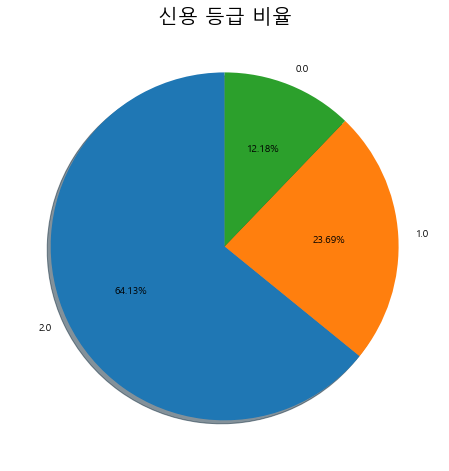

In [12]:
plt.subplots(figsize = (8,8))
plt.pie(train['credit'].value_counts(), labels = train['credit'].value_counts().index, 
        autopct="%.2f%%", shadow = True, startangle = 90)
plt.title('신용 등급 비율', size=20)
plt.show()

- 0: 신용도가 좋음 
- 2: 신용도가 낮음

- 2가 많은 것으로 보아 신용도가 낮은 사람들이 많다는 것을 알 수 있음.

In [13]:
# 등급에 따른 차이를 보기 위한 데이터 분류
train_0 = train[train['credit']==0.0]
train_1 = train[train['credit']==1.0]
train_2 = train[train['credit']==2.0]

- 신용 등급에 따른 차이를 알아보기 위해 Categorical 그래프 함수 생성

In [14]:
# Categorical 그래프 함수 정의
def categorical_plot(column):

  f, ax = plt.subplots(1, 3, figsize=(16, 6))


  sns.countplot(x = column,
                data = train_0,
                ax = ax[0],
                order = train_0[column].value_counts().index)
  ax[0].tick_params(labelsize=12)
  ax[0].set_title('credit = 0')
  ax[0].set_ylabel('count')
  ax[0].tick_params(rotation=50)


  sns.countplot(x = column,
                data = train_1,
                ax = ax[1],
                order = train_1[column].value_counts().index)
  ax[1].tick_params(labelsize=12)
  ax[1].set_title('credit = 1')
  ax[1].set_ylabel('count')
  ax[1].tick_params(rotation=50)

  sns.countplot(x = column,
                data = train_2,
                ax = ax[2],
                order = train_2[column].value_counts().index)
  ax[2].tick_params(labelsize=12)
  ax[2].set_title('credit = 2')
  ax[2].set_ylabel('count')
  ax[2].tick_params(rotation=50)
  plt.subplots_adjust(wspace=0.3, hspace=0.3)
  plt.show()

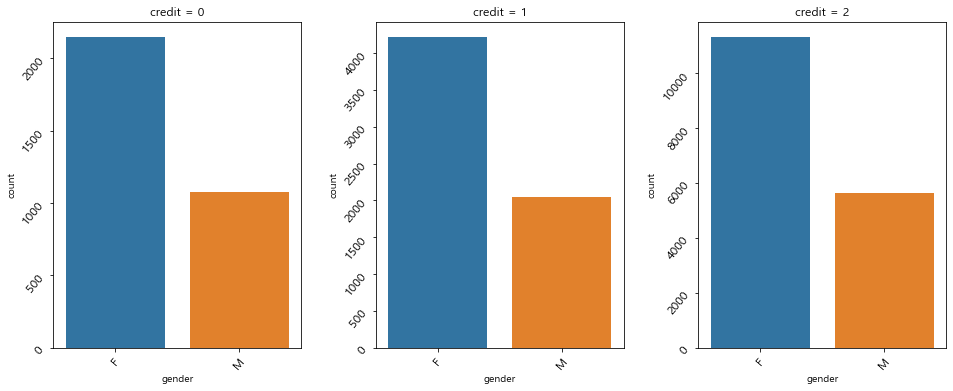

In [15]:
categorical_plot("gender")

- 모든 등급에서 여성이 더 많다라는 것을 알 수 있음.

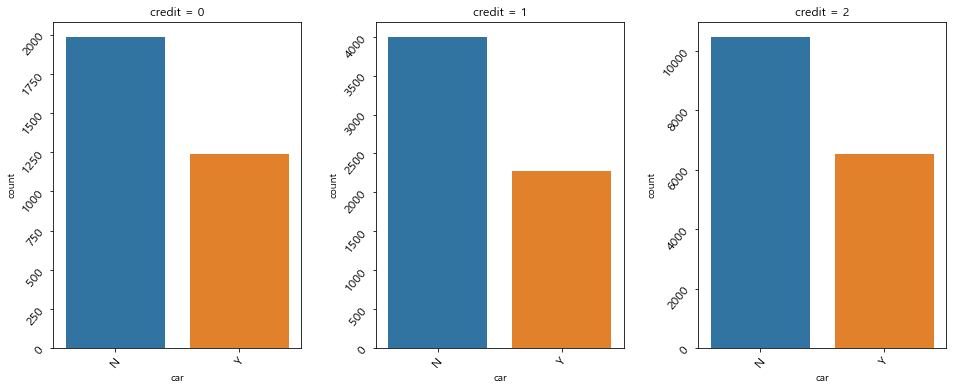

In [16]:
categorical_plot("car")

- 모든 등급에서 차를 갖고 있지 않은 사람들이 더 많음.

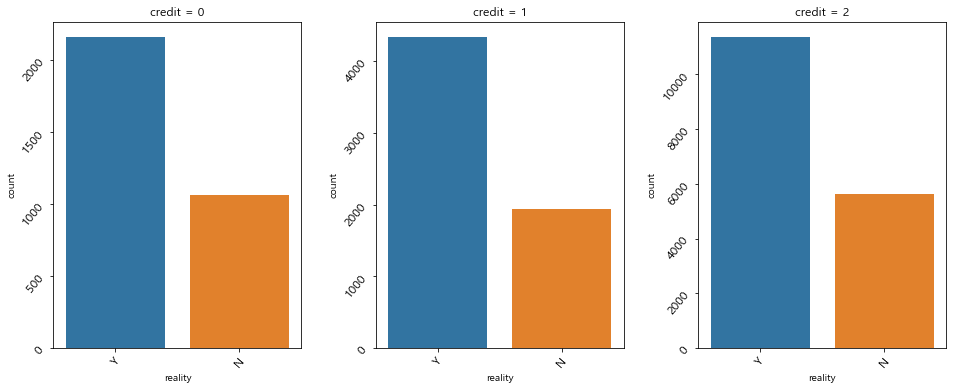

In [17]:
categorical_plot("reality")

- 모든 등급에서 부동산을 소유한 사람들이 더 많음.

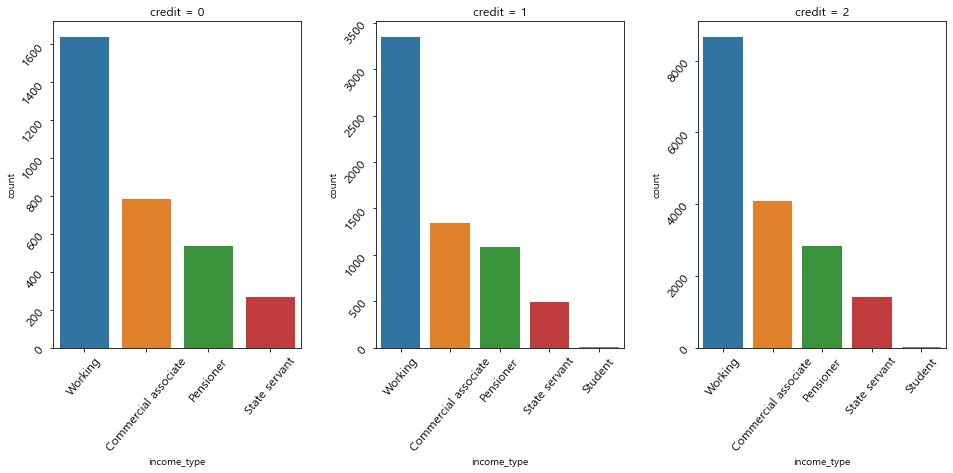

In [18]:
categorical_plot("income_type")

- 모든 등급에서 직장인들이 더 많음.

- credit 0 (신용등급이 높은 등급)에서는 Student가 존재하지 않음.

- Credit 1, 2 (신용등급이 낮은 등급)에서는 Student가 아주 조금 존재함.

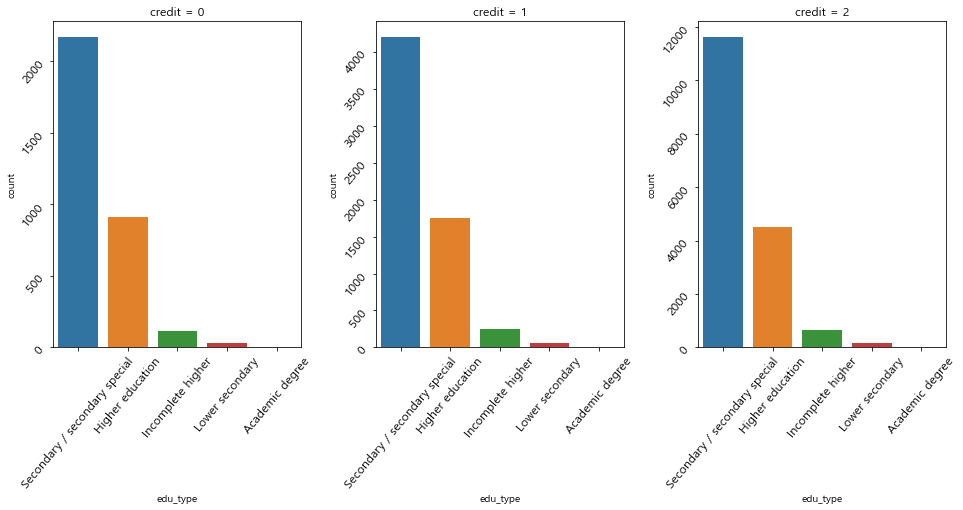

In [19]:
categorical_plot("edu_type")

- 모든 등급에서 교육 수준의 순위가 같음.

- Secondary / Secondary special : 중등 특수 교육
- Higher education : 고등 교육
- Incomplete higher : 대학에서 전체 과정을 이수하지 않았고 수료증을 받지 못했다는 것을 의미
- Lower secondary : 7th ~ 9th grades 중등교육
- Academic degree : 학사학위

- 미국의 고등학생은 졸업 이후의 진로를 대학 진학과 취업 사이에서 결정함 그리고 스스로에게 필요한 수업을 선택하여 수강함.

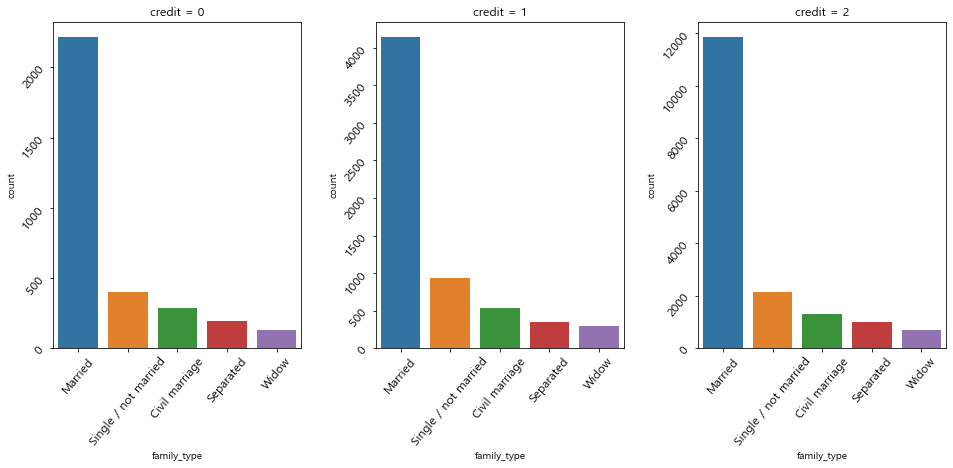

In [20]:
categorical_plot("family_type")

- 모든 등급에서 결혼한 사람들이 가장 많음.

- married: 결혼 
- single/not married : 미혼
- civil_marriage : 종교 의식을 하지 않는 결혼
- separated : 이혼 (배우자와 헤어진 뒤 재혼하지 않고 혼자 살고 있는 사람)
- widow : 사별 (배우자 중 한쪽이 사망한 뒤 재혼하지 않고 혼자 살고 있는 사람)

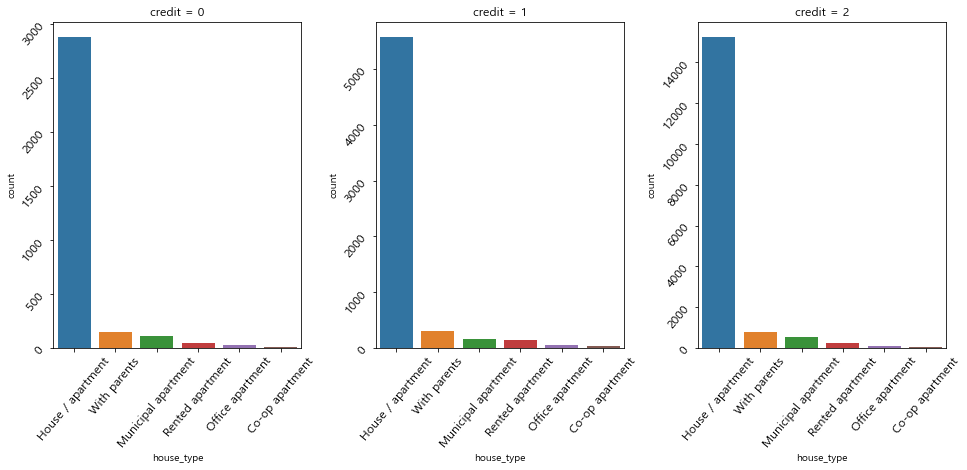

In [21]:
categorical_plot("house_type")

- house / apartment
- with parent
- Municipal apartment
- Rented apartment
- Office apartment
- Co-op apartment

- 모든 등급에서 순서가 같고, house / aprartment를 가진 사람들이 모든 등급에서 제일 높음.

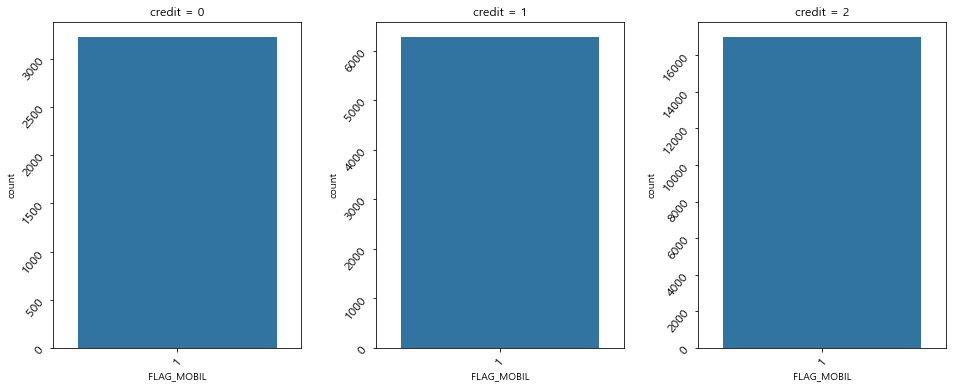

In [22]:
categorical_plot("FLAG_MOBIL") # 변수 제거해도 될듯

- FLAG_MOBIL은 핸드폰 소유 여부

- 모든 사람들이 휴대폰을 소유하고 있음.

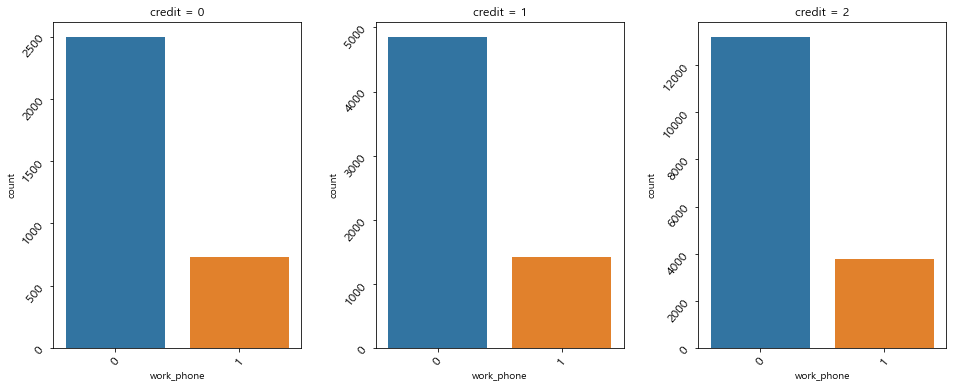

In [23]:
categorical_plot("work_phone")

- work_phone : 업무용 전화 소유 여부
    
- 모든 등급에서 업무용 전화를 소유하지 않는 사람들이 더 많음.

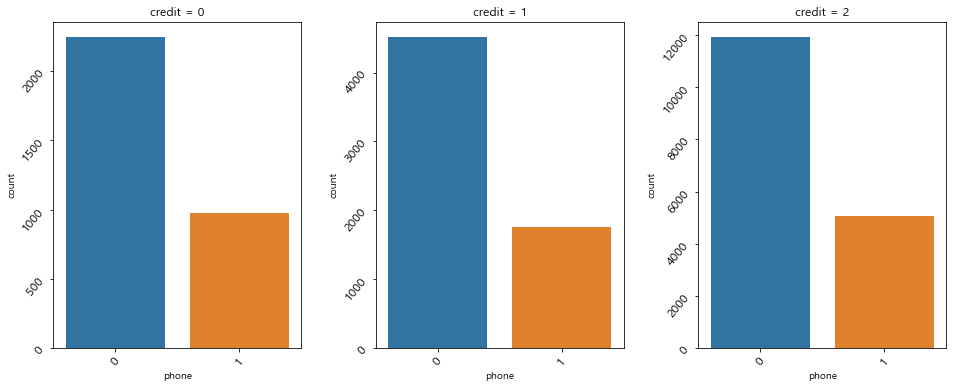

In [24]:
categorical_plot("phone")

- phone: 전화 소유 여부
- 모든 등급에서 가정용 전화를 소유하지 않는 사람들이 더 많음.

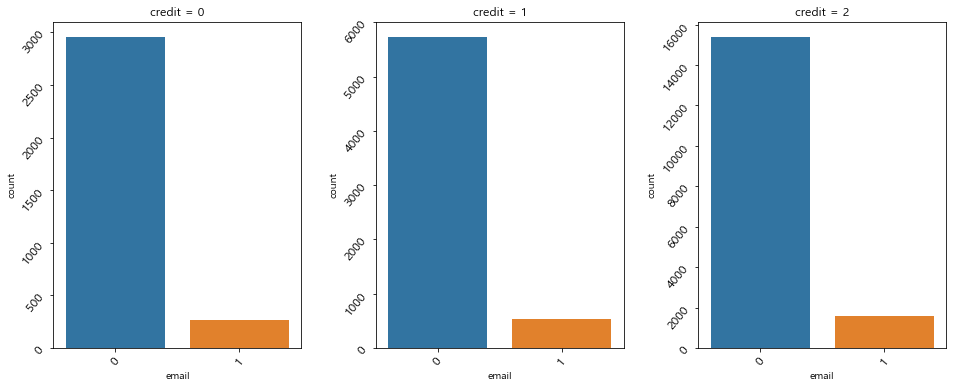

In [25]:
categorical_plot("email")

- email : 이메일 소유 여부
- 모든 등급에서 이메일을 소유하지 않는 사람들이 더 많음. 

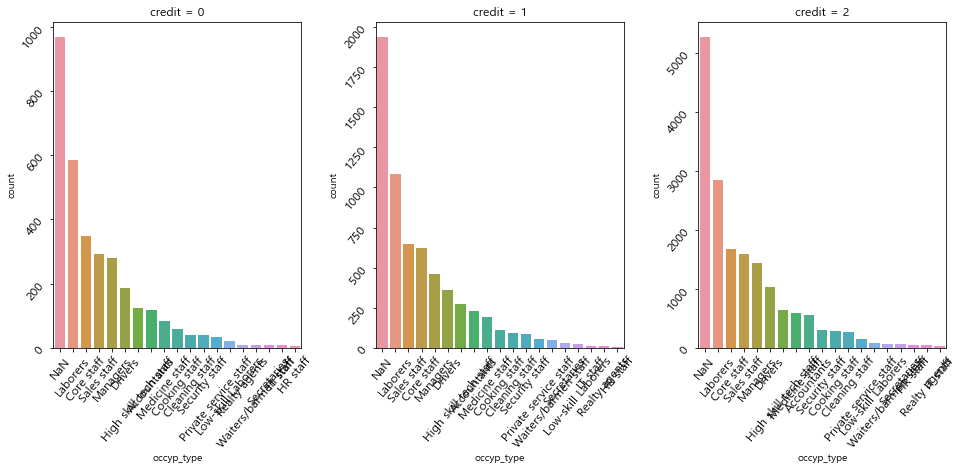

In [26]:
categorical_plot("occyp_type")

### 연속형 변수 EDA

- child_num, income_total, DAYS_BIRTH, DAYS_EMPLOYED, family_size, begin_month 6개 features

In [27]:
# Numerical 그래프 함수 정의
def numerical_plot(column):
  
  fig, axes = plt.subplots(1, 3, figsize=(16, 6))


  sns.distplot(train_0[column],
                ax = axes[0])
  axes[0].tick_params(labelsize=12)
  axes[0].set_title('credit = 0')
  axes[0].set_ylabel('count')

  sns.distplot(train_1[column],
                ax = axes[1])
  axes[1].tick_params(labelsize=12)
  axes[1].set_title('credit = 1')
  axes[1].set_ylabel('count')

  sns.distplot(train_2[column],
                ax = axes[2])
  axes[2].tick_params(labelsize=12)
  axes[2].set_title('credit = 2')
  axes[2].set_ylabel('count')
  plt.subplots_adjust(wspace=0.3, hspace=0.3)

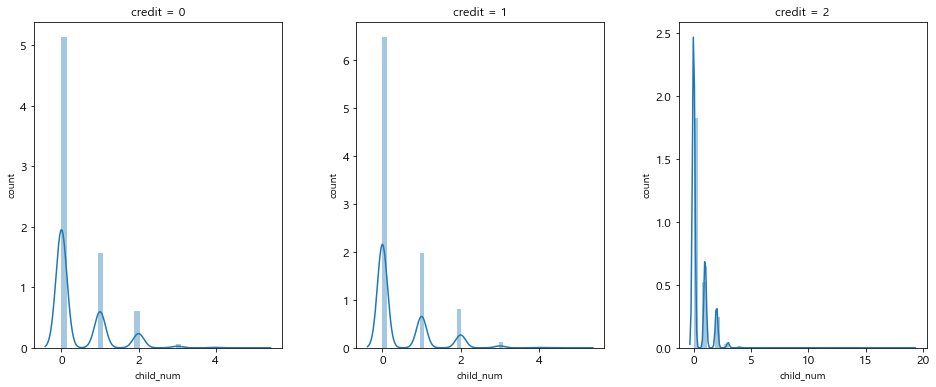

In [28]:
numerical_plot("child_num")

- 신용등급이 높은 2에서 자녀의 수가 0~2개가 가장 많음.
- 신용등급에 따라 자녀수의 차이는 존재하지 않는 것으로 보임.

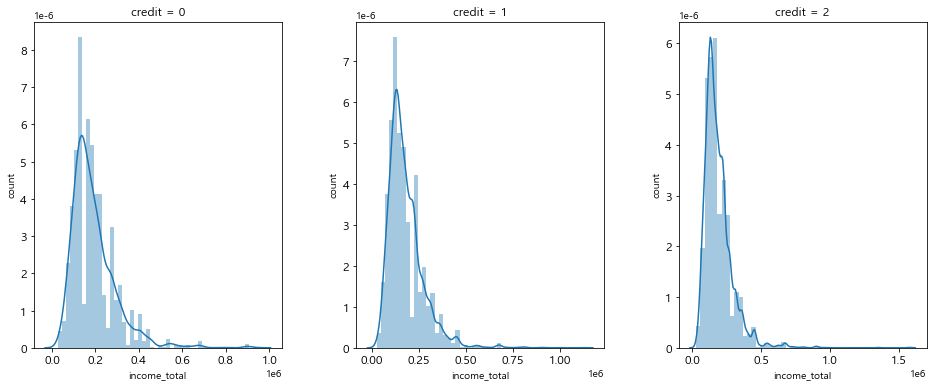

In [29]:
numerical_plot("income_total")

- 신용 등급에 따라 연간 소득의 차이는 존재하지 않는 것으로 보임.

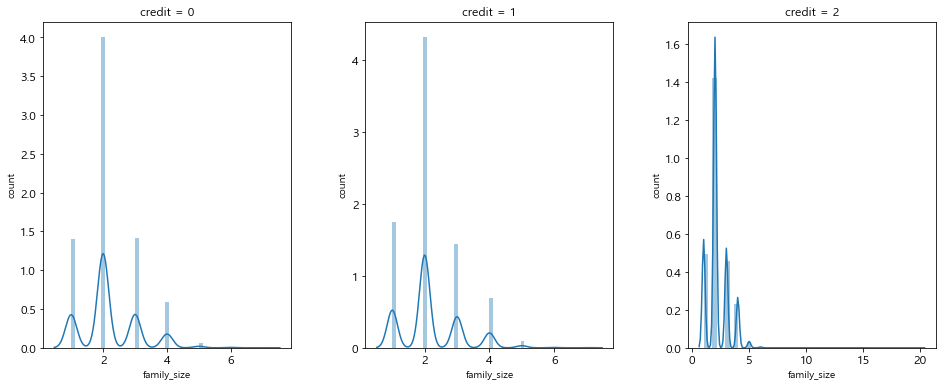

In [30]:
numerical_plot("family_size")

- 신용도가 높은 등급에서는 왼쪽으로 치우친 그래프임.
- 모든 등급에서 보통 가족 수가 2명인 사람들이 많음.

In [31]:
train['family_size'].value_counts()

2.0     14106
1.0      5109
3.0      4632
4.0      2260
5.0       291
6.0        44
7.0         9
15.0        3
9.0         2
20.0        1
Name: family_size, dtype: int64

In [32]:
test['family_size'].value_counts()

2.0    5357
1.0    1878
3.0    1789
4.0     846
5.0     106
6.0      14
7.0      10
Name: family_size, dtype: int64

test셋에는 7이하까지만 있으므로 
train 데이터셋에 7 이상인 것들은 제거해준다.

### 이상치 처리

In [33]:
train = train[(train['family_size'] <= 7)]
train = train.reset_index(drop=True)

In [34]:
train['family_size'].value_counts()

2.0    14106
1.0     5109
3.0     4632
4.0     2260
5.0      291
6.0       44
7.0        9
Name: family_size, dtype: int64

In [35]:
train.shape

(26451, 20)

In [36]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26451 entries, 0 to 26450
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          26451 non-null  int64  
 1   gender         26451 non-null  object 
 2   car            26451 non-null  object 
 3   reality        26451 non-null  object 
 4   child_num      26451 non-null  int64  
 5   income_total   26451 non-null  float64
 6   income_type    26451 non-null  object 
 7   edu_type       26451 non-null  object 
 8   family_type    26451 non-null  object 
 9   house_type     26451 non-null  object 
 10  DAYS_BIRTH     26451 non-null  int64  
 11  DAYS_EMPLOYED  26451 non-null  int64  
 12  FLAG_MOBIL     26451 non-null  int64  
 13  work_phone     26451 non-null  int64  
 14  phone          26451 non-null  int64  
 15  email          26451 non-null  int64  
 16  occyp_type     26451 non-null  object 
 17  family_size    26451 non-null  float64
 18  begin_

### X_train, y_train, X_test로 나눔

In [37]:
X_train = train.iloc[:,:-1]
y_train = train.iloc[:, -1]

X_train = X_train.drop(columns = ['FLAG_MOBIL'])

X_test = test
test_id = X_test.index
X_test = test.drop(columns = ['FLAG_MOBIL'])

In [38]:
X_train.shape, y_train.shape

((26451, 18), (26451,))

### 중복값 처리

In [39]:
X_train_cp = X_train.copy()
X_test_cp = X_test.copy()

In [40]:
X = pd.concat([X_train_cp,X_test_cp])

In [41]:
X_train.drop(columns=['begin_month','index']).shape

(26451, 16)

In [42]:
X_train.drop(columns=['begin_month','index']).drop_duplicates().shape

(8756, 16)

In [43]:
X = X.astype('str')

In [44]:
X['new'] = X['child_num']+X['income_total']+X['DAYS_BIRTH']+X['DAYS_EMPLOYED']+X['family_size']+X['gender']+X['car'] + \
    X['reality']+X['income_type']+X['edu_type']+X['family_size'] + \
    X['house_type']+X['work_phone']+X['phone']+X['email']+X['occyp_type']

In [45]:
X.drop(columns=['child_num', 'income_total' , 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'family_size','gender' , 'car', 'reality', 'income_type', 'edu_type', 'family_type', 'house_type',  'work_phone', 'phone', 'email', 'occyp_type'],inplace=True)

In [46]:
X.loc[:, 'new_factorize'] = pd.factorize(X['new'])[0].reshape(-1, 1)

In [47]:
X['new_factorize'].value_counts()

130     51
727     35
385     32
1255    28
1013    25
        ..
7368     1
2409     1
7372     1
7373     1
9704     1
Name: new_factorize, Length: 9705, dtype: int64

In [48]:
X_train_cp = X.iloc[:X_train.shape[0],:]
X_test_cp = X.iloc[X_train.shape[0]:,:]

In [49]:
X_train['id'] = X_train_cp['new_factorize']
X_test['id'] = X_test_cp['new_factorize']

In [50]:
X_train.drop(columns='index', inplace=True)
X_test.drop(columns='index', inplace=True)

## __Feature Engineering__

### DAYS_EMPLOYED

- 양수값은 고용되지 않은 상태를 의미하므로 무직자라고 생각함. 0으로 처리하기

In [51]:
X_train['DAYS_EMPLOYED'] = X_train['DAYS_EMPLOYED'].map(lambda x:0 if x >0 else x)
X_test['DAYS_EMPLOYED'] = X_test['DAYS_EMPLOYED'].map(lambda x:0 if x >0 else x)

### DAYS_BIRTH, DAYS_EMPLOYED, begin_month 
- 음수값 -> 양수값으로 변환하기

In [52]:
new_features = ['DAYS_BIRTH', 'DAYS_EMPLOYED', 'begin_month']
for features in new_features:
    X_train[features] = np.abs(X_train[features])
    X_test[features] = np.abs(X_test[features])

In [53]:
X_train.head()

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,occyp_type,family_size,begin_month,id
0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,13899,4709,0,0,0,NaN,2.0,6.0,0
1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,11380,1540,0,0,1,Laborers,3.0,5.0,1
2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,19087,4434,0,1,0,Managers,2.0,22.0,2
3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,15088,2092,0,1,0,Sales staff,2.0,37.0,3
4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,15037,2105,0,0,0,Managers,2.0,26.0,4


- 양수값으로 잘 변환한것을 알 수 있음.

### 'age' Feauture 생성 -> DAYS_BIRTH으로 변환 작업

In [54]:
X_train['age'] = round(X_train['DAYS_BIRTH']/365,0).astype(np.int32)
X_train.head(1)

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,occyp_type,family_size,begin_month,id,age
0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,13899,4709,0,0,0,NaN,2.0,6.0,0,38


In [55]:
X_test['age'] = round(X_test['DAYS_BIRTH']/365,0).astype(np.int32)
X_test.head(1)

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,occyp_type,family_size,begin_month,id,age
0,M,Y,N,0,112500.0,Pensioner,Secondary / secondary special,Civil marriage,House / apartment,21990,0,0,1,0,NaN,2.0,60.0,1401,60


### 시각화해서 분포 확인하기

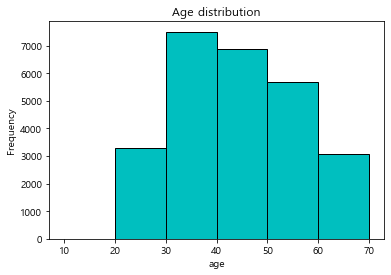

In [56]:
X_train['age'].plot.hist(bins = range(10,80,10), color = 'c', edgecolor = 'k')

plt.xlabel('age')
plt.title('Age distribution')
plt.show()

- 시각화한 결과, 데이터에 30, 40, 50대가 주로 이루고 있음

### 'age_group' feature 생성 -> age으로 변환 작업

In [57]:
X_train['age_group'] = X_train['age'].copy()
X_test['age_group'] = X_test['age'].copy()

In [58]:
X_train['age_group'] = X_train['age_group'].replace({21, 22, 23, 24, 25, 26, 27, 27, 28, 29}, '20대')
X_train['age_group'] = X_train['age_group'].replace({30, 31, 32, 33, 34, 35, 36, 37, 38, 39}, '30대')
X_train['age_group'] = X_train['age_group'].replace({40, 41, 42, 43, 44, 45, 46, 47, 48, 49}, '40대')
X_train['age_group'] = X_train['age_group'].replace({50, 51, 52, 53, 54, 55, 56, 57, 58, 59}, '50대')
X_train['age_group'] = X_train['age_group'].replace({60, 61, 62, 63, 64, 65, 66, 67, 68, 69}, '60대')


In [59]:
X_train['age_group'].value_counts()

30대    7505
40대    6886
50대    5695
20대    3284
60대    3081
Name: age_group, dtype: int64

In [60]:
X_test['age_group'] = X_test['age_group'].replace({21, 22, 23, 24, 25, 26, 27, 27, 28, 29}, '20대')
X_test['age_group'] = X_test['age_group'].replace({30, 31, 32, 33, 34, 35, 36, 37, 38, 39}, '30대')
X_test['age_group'] = X_test['age_group'].replace({40, 41, 42, 43, 44, 45, 46, 47, 48, 49}, '40대')
X_test['age_group'] = X_test['age_group'].replace({50, 51, 52, 53, 54, 55, 56, 57, 58, 59}, '50대')
X_test['age_group'] = X_test['age_group'].replace({60, 61, 62, 63, 64, 65, 66, 67, 68, 69}, '60대')


In [61]:
X_test['age_group'].value_counts()

30대    2805
40대    2608
50대    2209
20대    1191
60대    1187
Name: age_group, dtype: int64

### 'year of service' feature 생성 -> DAYS_EMPLOYED으로 변환 작업
- 근무년수

In [62]:
X_train['year_of_service'] = round(X_train['DAYS_EMPLOYED']/365,0).astype(np.int64)
X_train.head(1)

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,...,work_phone,phone,email,occyp_type,family_size,begin_month,id,age,age_group,year_of_service
0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,13899,...,0,0,0,NaN,2.0,6.0,0,38,30대,13


In [63]:
X_test['year_of_service'] = round(X_test['DAYS_EMPLOYED']/365,0).astype(np.int64)
X_test.head(5)

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,...,work_phone,phone,email,occyp_type,family_size,begin_month,id,age,age_group,year_of_service
0,M,Y,N,0,112500.0,Pensioner,Secondary / secondary special,Civil marriage,House / apartment,21990,...,0,1,0,NaN,2.0,60.0,1401,60,60대,0
1,F,N,Y,0,135000.0,State servant,Higher education,Married,House / apartment,18964,...,0,1,0,Core staff,2.0,36.0,311,52,50대,24
2,F,N,Y,0,69372.0,Working,Secondary / secondary special,Married,House / apartment,15887,...,1,1,0,Laborers,2.0,40.0,2736,44,40대,1
3,M,Y,N,0,112500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,19270,...,1,0,0,Drivers,2.0,41.0,8077,53,50대,7
4,F,Y,Y,0,225000.0,State servant,Higher education,Married,House / apartment,17822,...,1,0,0,Managers,2.0,8.0,5261,49,40대,26


### 'years_group' feature 생성 -> year_of_service으로 변환 작업
- 근무경력 기준

In [64]:
X_train['years_group'] = X_train['year_of_service'].copy()
X_test['years_group'] = X_test['year_of_service'].copy()

In [65]:
X_train['years_group'].value_counts(ascending = False)

0     5118
1     2322
2     2168
3     2159
4     2023
5     1755
6     1486
7     1404
8     1253
9     1118
10     877
11     665
15     556
12     532
13     492
14     355
20     237
17     225
16     207
19     203
18     171
21     158
22     129
23     115
24      96
27      87
26      84
25      84
28      67
29      55
30      42
33      42
31      29
41      28
34      25
32      21
35      20
36      11
40       9
38       8
37       7
39       5
43       3
Name: years_group, dtype: int64

In [66]:
X_train['years_group'] = X_train['years_group'].replace(0, '근무경력없음')
X_train['years_group'] = X_train['years_group'].replace({1,2,3}, '1~3년')
X_train['years_group'] = X_train['years_group'].replace({4,5,6}, '4~6년')
X_train['years_group'] = X_train['years_group'].replace({7,8,9}, '7~9년')
X_train['years_group'] = X_train['years_group'].replace({10,11,12,13,14,15}, '10~15년')
X_train['years_group'] = X_train['years_group'].replace({16,17,18,19,20}, '16~20년')
X_train['years_group'] = X_train['years_group'].replace({21,22,23,24,25}, '21년~25년')
X_train['years_group'] = X_train['years_group'].replace({26,27,28,29,30}, '26년~30년')
X_train['years_group'] = X_train['years_group'].replace({31,32,33,34,35,36,37,38,39,40,41,43}, '31년이상')

In [67]:
X_train['years_group'].value_counts()

1~3년       6649
4~6년       5264
근무경력없음     5118
7~9년       3775
10~15년     3477
16~20년     1043
21년~25년     582
26년~30년     335
31년이상       208
Name: years_group, dtype: int64

In [68]:
X_test['years_group'] = X_test['years_group'].replace(0, '근무경력없음')
X_test['years_group'] = X_test['years_group'].replace({1,2,3}, '1~3년')
X_test['years_group'] = X_test['years_group'].replace({4,5,6}, '4~6년')
X_test['years_group'] = X_test['years_group'].replace({7,8,9}, '7~9년')
X_test['years_group'] = X_test['years_group'].replace({10,11,12,13,14,15}, '10~15년')
X_test['years_group'] = X_test['years_group'].replace({16,17,18,19,20}, '16~20년')
X_test['years_group'] = X_test['years_group'].replace({21,22,23,24,25}, '21년~25년')
X_test['years_group'] = X_test['years_group'].replace({26,27,28,29,30}, '26년~30년')
X_test['years_group'] = X_test['years_group'].replace({31,32,33,34,35,36,37,38,39,40,41,42, 43}, '31년이상')

In [69]:
X_test['years_group'].value_counts()

1~3년       2430
4~6년       2055
근무경력없음     1922
7~9년       1478
10~15년     1282
16~20년      412
21년~25년     235
26년~30년     106
31년이상        80
Name: years_group, dtype: int64

### DAYS_BIRTH_month, DAYS_BIRTH_week 피처 생성 
- DAYS_BIRTH 변환 작업

In [70]:
# DAYS_BIRTH
X_train['DAYS_BIRTH_month']=np.floor((X_train['DAYS_BIRTH'])/30)-((np.floor((X_train['DAYS_BIRTH'])/30)/12).astype(int)*12)
X_train['DAYS_BIRTH_week']=np.floor((X_train['DAYS_BIRTH'])/7)-((np.floor((X_train['DAYS_BIRTH'])/7)/4).astype(int)*4)

In [71]:
X_train['DAYS_BIRTH_month'] = X_train['DAYS_BIRTH_month'].astype(int)
X_train['DAYS_BIRTH_week'] = X_train['DAYS_BIRTH_week'].astype(int)

In [72]:
X_test['DAYS_BIRTH_month']=np.floor((X_test['DAYS_BIRTH'])/30)-((np.floor((X_test['DAYS_BIRTH'])/30)/12).astype(int)*12)
X_test['DAYS_BIRTH_week']=np.floor((X_test['DAYS_BIRTH'])/7)-((np.floor((X_test['DAYS_BIRTH'])/7)/4).astype(int)*4)

In [73]:
X_test['DAYS_BIRTH_month'] = X_test['DAYS_BIRTH_month'].astype(int)
X_test['DAYS_BIRTH_week'] = X_test['DAYS_BIRTH_week'].astype(int)

### DAYS_EMPLOYED_month, DAYS_EMPLOYED_week 피처 생성
- DAYS_EMPLOYED 변환 작업

In [74]:
# DAYS_EMPLOYED
X_train['DAYS_EMPLOYED_month']=np.floor((X_train['DAYS_EMPLOYED'])/30)-((np.floor((X_train['DAYS_EMPLOYED'])/30)/12).astype(int)*12)
X_train['DAYS_EMPLOYED_week']=np.floor((X_train['DAYS_EMPLOYED'])/7)-((np.floor((X_train['DAYS_EMPLOYED'])/7)/4).astype(int)*4)

In [75]:
X_train['DAYS_EMPLOYED_month'] = X_train['DAYS_EMPLOYED_month'].astype(int)
X_train['DAYS_EMPLOYED_week'] = X_train['DAYS_EMPLOYED_week'].astype(int)

In [76]:
X_test['DAYS_EMPLOYED_month']=np.floor((X_test['DAYS_EMPLOYED'])/30)-((np.floor((X_test['DAYS_EMPLOYED'])/30)/12).astype(int)*12)
X_test['DAYS_EMPLOYED_week']=np.floor((X_test['DAYS_EMPLOYED'])/7)-((np.floor((X_test['DAYS_EMPLOYED'])/7)/4).astype(int)*4)

In [77]:
X_test['DAYS_EMPLOYED_month'] = X_test['DAYS_EMPLOYED_month'].astype(int)
X_test['DAYS_EMPLOYED_week'] = X_test['DAYS_EMPLOYED_week'].astype(int)

### DAYS_EMPLOYED_month, DAYS_EMPLOYED_week 피처 생성
- DAYS_EMPLOYED 변환 작업

In [78]:
# before_EMPLOYED: 고용되기 전까지의 일수

X_train['before_EMPLOYED']= X_train['DAYS_BIRTH']-X_train['DAYS_EMPLOYED']

In [79]:
X_train['before_EMPLOYED_month']=np.floor((X_train['before_EMPLOYED'])/30)-((np.floor((X_train['before_EMPLOYED'])/30)/12).astype(int)*12)
X_train['before_EMPLOYED_week']=np.floor((X_train['before_EMPLOYED'])/7)-((np.floor((X_train['before_EMPLOYED'])/7)/4).astype(int)*4)

In [80]:
X_train['before_EMPLOYED'] = X_train['before_EMPLOYED'].astype(int)
X_train['before_EMPLOYED_month'] = X_train['before_EMPLOYED_month'].astype(int)
X_train['before_EMPLOYED_week'] = X_train['before_EMPLOYED_week'].astype(int)

In [81]:
# before_EMPLOYED: 고용되기 전까지의 일수

X_test['before_EMPLOYED']= X_test['DAYS_BIRTH']-X_test['DAYS_EMPLOYED']
X_test['before_EMPLOYED_month']=np.floor((X_test['before_EMPLOYED'])/30)-((np.floor((X_train['before_EMPLOYED'])/30)/12).astype(int)*12)
X_test['before_EMPLOYED_week']=np.floor((X_test['before_EMPLOYED'])/7)-((np.floor((X_train['before_EMPLOYED'])/7)/4).astype(int)*4)

In [82]:
X_test['before_EMPLOYED'] = X_test['before_EMPLOYED'].astype(int)
X_test['before_EMPLOYED_month'] = X_test['before_EMPLOYED_month'].astype(int)
X_test['before_EMPLOYED_week'] = X_test['before_EMPLOYED_week'].astype(int)

### DAYS_BIRTH 범주화

In [83]:
a = []

for i in X_train['DAYS_BIRTH']:
    if i<=X_train['DAYS_BIRTH'].quantile(q=0.25):
        a.append(1)
    elif i<=X_train['DAYS_BIRTH'].quantile(q=0.5):
        a.append(2)
    elif i<=X_train['DAYS_BIRTH'].quantile(q=0.75):
        a.append(3)
    else:
        a.append(4)

X_train['DAYS_BIRTH_class'] = a

a = []

for i in X_test['DAYS_BIRTH']:
    if i<=X_test['DAYS_BIRTH'].quantile(q=0.25):
        a.append(1)
    elif i<=X_test['DAYS_BIRTH'].quantile(q=0.5):
        a.append(2)
    elif i<=X_test['DAYS_BIRTH'].quantile(q=0.75):
        a.append(3)
    else:
        a.append(4)

X_test['DAYS_BIRTH_class'] = a

### begin_month 범주화

In [84]:
a = []

for i in X_train['begin_month']:
    if i <= X_train['begin_month'].quantile(q=0.25):
        a.append(1)
    elif i <= X_train['begin_month'].quantile(q=0.5):
        a.append(2)
    elif i <= X_train['begin_month'].quantile(q=0.75):
        a.append(3)
    else:
        a.append(4)

X_train['begin_month_class'] = a

a = []

for i in X_test['begin_month']:
    if i <= X_test['begin_month'].quantile(q=0.25):
        a.append(1)
    elif i <= X_test['begin_month'].quantile(q=0.5):
        a.append(2)
    elif i <= X_test['begin_month'].quantile(q=0.75):
        a.append(3)
    else:
        a.append(4)

X_test['begin_month_class'] = a


### income_total*10000

In [85]:
X_train['income_total'] = X_train['income_total'].astype(float)
X_test['income_total'] = X_test['income_total'].astype(float)

X_train['income_total*10000'] = X_train['income_total']/10000 
X_test['income_total*10000'] = X_test['income_total']/10000

### income_total_dev & income_total_log

In [86]:
def numeric_process(data):

    # 편차 제곱 변수 생성
    data['income_total_dev'] = (
        data['income_total*10000'] - data['income_total*10000'].mean())**2

    # 로그 변환
    data['income_total_log'] = data['income_total*10000'].apply(np.log1p)

    return data


X_train = numeric_process(X_train)
X_test = numeric_process(X_test)

### 연간소득/가족규모

In [87]:
X_train['소득/가족'] = X_train['income_total'] / X_train['family_size']
X_test['소득/가족'] = X_test['income_total'] / X_test['family_size']

### 연간소득/자녀수

In [88]:
X_train['소득/자녀'] = X_train['income_total'] / X_train['child_num']
X_test['소득/자녀'] = X_test['income_total'] / X_test['child_num']

### 소득분류별 연간소득

In [89]:
object1 = X_train.groupby('income_type')['income_total'].agg([('income_type__총income_total', np.sum),
                                            ('income_type_평균income_total', np.mean),
                                            ('income_type_최대income_total', np.max),
                                            ('income_type__최소income_total', np.min),
                                            ('income_type__income_total표준편차', np.std),   
                                            ('income_type__income_total변동계수', lambda x : np.std(x)/np.mean(x))]).reset_index().fillna(0)
X_train= pd.merge(X_train, object1, on = 'income_type', how='left')



object2 = X_test.groupby('income_type')['income_total'].agg([('income_type__총income_total', np.sum),
                                            ('income_type_평균income_total', np.mean),
                                            ('income_type_최대income_total', np.max),
                                            ('income_type__최소income_total', np.min),
                                            ('income_type__income_total표준편차', np.std),   
                                            ('income_type__income_total변동계수', lambda x : np.std(x)/np.mean(x))]).reset_index().fillna(0)
X_test= pd.merge(X_test, object2, on = 'income_type', how='left')

### 교육수준별 연간소득

In [90]:
object3 = X_train.groupby('edu_type')['income_total'].agg([('edu_type__총income_total', np.sum),
                                            ('edu_type_평균income_total', np.mean),
                                            ('edu_type_최대income_total', np.max),
                                            ('edu_type__최소income_total', np.min),
                                            ('edu_type__income_total표준편차', np.std),   
                                            ('edu_type__income_total변동계수', lambda x : np.std(x)/np.mean(x))]).reset_index().fillna(0)
X_train= pd.merge(X_train, object3, on = 'edu_type', how='left')



object4 = X_test.groupby('edu_type')['income_total'].agg([('edu_type__총income_total', np.sum),
                                            ('edu_type_평균income_total', np.mean),
                                            ('edu_type_최대income_total', np.max),
                                            ('edu_type__최소income_total', np.min),
                                            ('edu_type__income_total표준편차', np.std),   
                                            ('edu_type__income_total변동계수', lambda x : np.std(x)/np.mean(x))]).reset_index().fillna(0)
X_test= pd.merge(X_test, object4, on = 'edu_type', how='left')

### 결혼여부별 연간소득

In [91]:
object5 = X_train.groupby('family_type')['income_total'].agg([('family_type__총income_total', np.sum),
                                            ('family_type_평균income_total', np.mean),
                                            ('family_type_최대income_total', np.max),
                                            ('family_type__최소income_total', np.min),
                                            ('family_type__income_total표준편차', np.std),   
                                            ('family_type__income_total변동계수', lambda x : np.std(x)/np.mean(x))]).reset_index().fillna(0)
X_train= pd.merge(X_train, object5, on = 'family_type', how='left')



object6 = X_test.groupby('family_type')['income_total'].agg([('family_type__총income_total', np.sum),
                                            ('family_type_평균income_total', np.mean),
                                            ('family_type_최대income_total', np.max),
                                            ('family_type__최소income_total', np.min),
                                            ('family_type__income_total표준편차', np.std),   
                                            ('family_type__income_total변동계수', lambda x : np.std(x)/np.mean(x))]).reset_index().fillna(0)
X_test= pd.merge(X_test, object6, on = 'family_type', how='left')

### 생활방식별 연간소득

In [92]:
object7 = X_train.groupby('house_type')['income_total'].agg([('house_type__총income_total', np.sum),
                                            ('house_type_평균income_total', np.mean),
                                            ('house_type_최대income_total', np.max),
                                            ('house_type__최소income_total', np.min),
                                            ('house_type__income_total표준편차', np.std),   
                                            ('house_type__income_total변동계수', lambda x : np.std(x)/np.mean(x))]).reset_index().fillna(0)
X_train= pd.merge(X_train, object7, on = 'house_type', how='left')



object8 = X_test.groupby('house_type')['income_total'].agg([('house_type__총income_total', np.sum),
                                            ('house_type_평균income_total', np.mean),
                                            ('house_type_최대income_total', np.max),
                                            ('house_type__최소income_total', np.min),
                                            ('house_type__income_total표준편차', np.std),   
                                            ('house_type__income_total변동계수', lambda x : np.std(x)/np.mean(x))]).reset_index().fillna(0)
X_test= pd.merge(X_test, object8, on = 'house_type', how='left')

### 나이대별 연간소득

In [93]:
object9 = X_train.groupby('age_group')['income_total'].agg([('Age_type__총income_total', np.sum),
                                            ('Age_type_평균income_total', np.mean),
                                            ('Age_type_최대income_total', np.max),
                                            ('Age_type__최소income_total', np.min),
                                            ('Age_type__income_total표준편차', np.std),   
                                            ('Age_type__income_total변동계수', lambda x : np.std(x)/np.mean(x))]).reset_index().fillna(0)
X_train= pd.merge(X_train, object9, on = 'age_group', how='left')



object10 = X_test.groupby('age_group')['income_total'].agg([('Age_type__총income_total', np.sum),
                                            ('Age_type_평균income_total', np.mean),
                                            ('Age_type_최대income_total', np.max),
                                            ('Age_type__최소income_total', np.min),
                                            ('Age_type__income_total표준편차', np.std),   
                                            ('Age_type__income_total변동계수', lambda x : np.std(x)/np.mean(x))]).reset_index().fillna(0)
X_test= pd.merge(X_test, object10, on = 'age_group', how='left')

### 직업유형별 연간소득

In [94]:
object11 = X_train.groupby('occyp_type')['income_total'].agg([('occyp_type__총income_total', np.sum),
                                            ('occyp_type_평균income_total', np.mean),
                                            ('occyp_type_최대income_total', np.max),
                                            ('occyp_type__최소income_total', np.min),
                                            ('occyp_type__income_total표준편차', np.std),   
                                            ('occyp_type__income_total변동계수', lambda x : np.std(x)/np.mean(x))]).reset_index().fillna(0)
X_train= pd.merge(X_train, object11, on = 'occyp_type', how='left')



object12 = X_test.groupby('occyp_type')['income_total'].agg([('occyp_type__총income_total', np.sum),
                                            ('occyp_type_평균income_total', np.mean),
                                            ('occyp_type_최대income_total', np.max),
                                            ('occyp_type__최소income_total', np.min),
                                            ('occyp_type__income_total표준편차', np.std),   
                                            ('occyp_type__income_total변동계수', lambda x : np.std(x)/np.mean(x))]).reset_index().fillna(0)
X_test= pd.merge(X_test, object12, on = 'occyp_type', how='left')

### EMPLOYED_RATIO

In [95]:
X_train['EMPLOYED_RATIO'] = X_train['DAYS_EMPLOYED'] / X_train['DAYS_BIRTH']
X_test['EMPLOYED_RATIO'] = X_test['DAYS_EMPLOYED'] / X_test['DAYS_BIRTH']

### income_per_days_birth

In [96]:
X_train['income_per_days_birth'] = X_train['income_total'] / X_train['DAYS_BIRTH']
X_test['income_per_days_birth'] = X_test['income_total'] / X_test['DAYS_BIRTH']

### income_per_days_birth_X_DAYS_BIRTH

In [97]:
X_train['income_per_days_birth_X_DAYS_BIRTH'] = X_train['income_per_days_birth'] * X_train['DAYS_BIRTH']
X_test['income_per_days_birth_X_DAYS_BIRTH'] = X_test['income_per_days_birth'] * X_test['DAYS_BIRTH']

### begin_month_X_DAYS_BIRTH

In [98]:
X_train['begin_month_X_DAYS_BIRTH'] = X_train['begin_month'] * X_train['DAYS_BIRTH']
X_test['begin_month_X_DAYS_BIRTH'] = X_test['begin_month'] * X_test['DAYS_BIRTH']

### BIRTH*id

In [99]:
X_train['BIRTH*id'] = X_train['DAYS_BIRTH'] * X_train['id']
X_test['BIRTH*id'] = X_test['DAYS_BIRTH'] * X_test['id']

### EMP*id

In [100]:
X_train['EMP*id'] = X_train['DAYS_EMPLOYED'] * X_train['id']
X_test['EMP*id'] = X_test['DAYS_EMPLOYED'] * X_test['id']

### BIRTH*EMP

In [101]:
X_train['BIRTH*EMP'] = X_train['DAYS_BIRTH'] * X_train['DAYS_EMPLOYED']
X_test['BIRTH*EMP'] = X_test['DAYS_BIRTH'] * X_test['DAYS_EMPLOYED']

### possible

In [102]:
X_train['possible'] = X_train['income_total'] / (X_train['DAYS_BIRTH'] + X_train['DAYS_EMPLOYED'])
X_test['possible'] = X_test['income_total'] / (X_test['DAYS_BIRTH'] + X_test['DAYS_EMPLOYED'])

### possible_class

In [103]:
a = []

for i in X_train['possible'].clip(0, 35):
    if i <= 5:
        a.append(1)
    elif i <= 10:
        a.append(2)
    elif i <= 15:
        a.append(3)
    elif i <= 20:
        a.append(4)
    elif i <= 25:
        a.append(5)
    elif i <= 30:
        a.append(6)
    elif i <= 35:
        a.append(7)

X_train['possible_class'] = a

a = []

for i in X_test['possible'].clip(0, 35):
    if i <= 5:
        a.append(1)
    elif i <= 10:
        a.append(2)
    elif i <= 15:
        a.append(3)
    elif i <= 20:
        a.append(4)
    elif i <= 25:
        a.append(5)
    elif i <= 30:
        a.append(6)
    elif i <= 35:
        a.append(7)

X_test['possible_class'] = a

### car_reality

In [104]:
X_train['car_reality'] = X_train['car'] + X_train['reality']
X_test['car_reality'] = X_test['car'] + X_test['reality']

### ID + DAYS_BIRTH

In [105]:
object1 = X_train.groupby('id')['DAYS_BIRTH'].agg([('id_총DAYS_BIRTH', np.sum),
                                           #  ('구매건수', np.size),
                                            ('id_평균DAYS_BIRTH', np.mean),
                                            ('id_최대DAYS_BIRTH', np.max),
                                            ('id_최소DAYS_BIRTH', np.min),
                                            ('id_DAYS_BIRTH표준편차', np.std),   
                                            ('id_DAYS_BIRTH변동계수', lambda X_train : np.std(X_train)/np.mean(X_train))]).reset_index().fillna(0)

X_train= pd.merge(X_train, object1, on = 'id', how='left')

object1 = X_test.groupby('id')['DAYS_BIRTH'].agg([('id_총DAYS_BIRTH', np.sum),
                                           #  ('구매건수', np.size),
                                            ('id_평균DAYS_BIRTH', np.mean),
                                            ('id_최대DAYS_BIRTH', np.max),
                                            ('id_최소DAYS_BIRTH', np.min),
                                            ('id_DAYS_BIRTH표준편차', np.std),   
                                            ('id_DAYS_BIRTH변동계수', lambda X_test : np.std(X_test)/np.mean(X_test))]).reset_index().fillna(0)

X_test= pd.merge(X_test, object1, on = 'id', how='left')

###  ID + begin_month

In [106]:
object90 = X_train.groupby('id')['begin_month'].agg([('id_총begin_months5', np.sum),
                                           #  ('구매건수', np.size),
                                            ('id_평균begin_month', np.mean),
                                            ('id_최대begin_month', np.max),
                                            ('id_최소begin_month', np.min),
                                            ('id_begin_month표준편차', np.std),   
                                            ('id_begin_month변동계수', lambda X_train : np.std(X_train)/np.mean(X_train))]).reset_index().fillna(0)

X_train= pd.merge(X_train, object90, on = 'id', how='left')

object91 = X_test.groupby('id')['begin_month'].agg([('id_총begin_months5', np.sum),
                                           #  ('구매건수', np.size),
                                            ('id_평균begin_month', np.mean),
                                            ('id_최대begin_month', np.max),
                                            ('id_최소begin_month', np.min),
                                            ('id_begin_month표준편차', np.std),   
                                            ('id_begin_month변동계수', lambda X_test : np.std(X_test)/np.mean(X_test))]).reset_index().fillna(0)

X_test= pd.merge(X_test, object91, on = 'id', how='left')

### possible 범주화 + begin_month_class 범주화 + DAYS_BIRTH_class 범주화

In [107]:
X_train['pos+beg+dBirth'] = X_train['possible_class'] + X_train['begin_month_class'] + X_train['DAYS_BIRTH_class']
X_test['pos+beg+dBirth'] = X_test['possible_class'] + X_test['begin_month_class'] + X_test['DAYS_BIRTH_class']

### income/before_EMPLOYED

In [108]:
X_train['income/before_EMPLOYED'] = X_train['income_total'] / X_train['before_EMPLOYED']
X_test['income/before_EMPLOYED'] = X_test['income_total'] / X_test['before_EMPLOYED']

### edu_type 별 신뢰도 0의 비율

In [109]:
a = []

for i in X_train['edu_type']:
    if i == 'Academic degree':
        a.append(0.08)
    elif i == 'Higher education':
        a.append(0.126)
    elif i == 'Incomplete higher':
        a.append(0.111)
    elif i == 'Lower Secondary':
        a.append(0.108)
    else:
        a.append(0.12)

X_train['edu_type_num'] = a

a = []

for i in X_test['edu_type']:
    if i == 'Academic degree':
        a.append(0.08)
    elif i == 'Higher education':
        a.append(0.126)
    elif i == 'Incomplete higher':
        a.append(0.111)
    elif i == 'Lower Secondary':
        a.append(0.108)
    else:
        a.append(0.12)


X_test['edu_type_num'] = a


### edu_type_num / DAYS_BIRTH 

In [110]:
X_train['edu_type_num/DAYS_BIRTH'] = (X_train['edu_type_num'] / X_train['DAYS_BIRTH'])*10000
X_test['edu_type_num/DAYS_BIRTH'] = (X_test['edu_type_num'] / X_test['DAYS_BIRTH'])*10000

### edu_type_num * income_per_days_birth

In [111]:
X_train['edu_type_num*income_per_days_birth'] = X_train['edu_type_num'] * X_train['income_per_days_birth']
X_test['edu_type_num*income_per_days_birth'] = X_test['edu_type_num'] * X_test['income_per_days_birth']

### 데이터 타입 변경

In [112]:
X_train['family_size'] = X_train['family_size'].astype(int)
X_test['family_size'] = X_test['family_size'].astype(int)

X_train['age'] = X_train['age'].astype('int64')
X_test['age'] = X_test['age'].astype('int64')

X_train['year_of_service'] = X_train['year_of_service'].astype('int64')
X_test['year_of_service'] = X_test['year_of_service'].astype('int64')

## __CatBoost__

In [113]:
numeric_features = ['income_total', 'family_size', 'begin_month', 'age', 'year_of_service',
                    'DAYS_BIRTH_month', 'DAYS_BIRTH_week', 'DAYS_EMPLOYED_month', 'DAYS_EMPLOYED_week',
                    'before_EMPLOYED', 'before_EMPLOYED_month', 'before_EMPLOYED_week','소득/가족','소득/자녀',
                    'BIRTH*id', 'EMP*id', 'BIRTH*EMP', 'possible','id_총DAYS_BIRTH','id_평균DAYS_BIRTH', 'id_최대DAYS_BIRTH', 'id_최소DAYS_BIRTH', 'id_DAYS_BIRTH표준편차', 'id_DAYS_BIRTH변동계수',
                    'income_type__총income_total', 'income_type_평균income_total', 'income_type_최대income_total', 'income_type__최소income_total', 'income_type__income_total표준편차', 'income_type__income_total변동계수',
                    'edu_type__총income_total', 'edu_type_평균income_total', 'edu_type_최대income_total', 'edu_type__최소income_total','edu_type__income_total표준편차','edu_type__income_total변동계수',
                    'family_type__총income_total', 'family_type_평균income_total', 'family_type_최대income_total', 'family_type__최소income_total','family_type__income_total표준편차','family_type__income_total변동계수',
                    'house_type__총income_total','house_type_평균income_total','house_type_최대income_total','house_type__최소income_total','house_type__income_total표준편차','house_type__income_total변동계수',
                    'Age_type__총income_total','Age_type_평균income_total','Age_type_최대income_total','Age_type__최소income_total','Age_type__income_total표준편차','Age_type__income_total변동계수',
                    'EMPLOYED_RATIO','income_per_days_birth','income_per_days_birth_X_DAYS_BIRTH','begin_month_X_DAYS_BIRTH',
                    'occyp_type__총income_total','occyp_type_평균income_total','occyp_type_최대income_total','occyp_type__최소income_total','occyp_type__income_total표준편차','occyp_type__income_total변동계수',
                    'income/before_EMPLOYED','income_total_dev','income_total_log','edu_type_num','edu_type_num/DAYS_BIRTH','edu_type_num*income_per_days_birth']
categorical_features= ['gender', 'car', 'reality', 'income_type', 'edu_type', 'family_type', 'house_type', 'occyp_type',
                       'age_group', 'years_group', 'id','work_phone','phone','email','DAYS_BIRTH_class','possible_class',
                       'car_reality','begin_month_class','pos+beg+dBirth']

X_train = X_train[numeric_features+categorical_features]
X_test = X_test[numeric_features+categorical_features]

In [1]:
num_train = X_train[numeric_features]
num_test = X_test[numeric_features]

NameError: name 'X_train' is not defined

In [115]:
# Method: Using SHAP values
import shap

# DF, based on which importance is checked
X_importance = num_test

# Explain model predictions using shap library:
model = CatBoostClassifier(verbose=False, random_state=0).fit(num_train, y_train)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_importance)

# Plot summary_plot as barplot:
shap.summary_plot(shap_values, X_importance, plot_type='bar')


In [116]:
shap_sum = np.abs(shap_values).mean(axis=1)[1, :]
importance_df = pd.DataFrame(
    [X_importance.columns.tolist(), shap_sum.tolist()]).T
importance_df.columns = ['column_name', 'shap_importance']
importance_df = importance_df.sort_values('shap_importance', ascending=False)
importance_df


In [117]:
# feature 중요도가 0 이상
SHAP_THRESHOLD = 0
features_selected = importance_df.query('shap_importance > @SHAP_THRESHOLD').column_name.tolist()

In [ ]:
X_train = num_train[features_selected] + X_train[categorical_features]
X_test = num_test[features_selected] + X_test[categorical_features]

In [118]:
from sklearn.model_selection import StratifiedKFold

skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
folds = []
for train_index, valid_index in skfold.split(X_train, y_train):
    folds.append((train_index, valid_index))

cat_pred = np.zeros((X_train.shape[0], 3))
cat_pred_test = np.zeros((X_test.shape[0], 3))

for fold in range(5):
  print(f'\n training model for CV {fold} \n')
  train_index, valid_index = folds[fold]
  train_x, valid_x = X_train.iloc[train_index], X_train.iloc[valid_index]
  train_y, valid_y = y_train.iloc[train_index], y_train.iloc[valid_index]

  model = CatBoostClassifier(
      cat_features=categorical_features, verbose=False, random_state=0)
  model.fit(train_x, train_y,
            eval_set=[(valid_x, valid_y)],
            early_stopping_rounds=100,
            )

  cat_pred[valid_index] = model.predict_proba(valid_x)
  cat_pred_test += model.predict_proba(X_test) / 5
  print(f'CV Log Loss Score: {log_loss(valid_y, cat_pred[valid_index]):.6f}')

print(f'\tLog Loss: {log_loss(y_train, cat_pred):.6f}')



 training model for CV 0 

CV Log Loss Score: 0.671601

 training model for CV 1 

CV Log Loss Score: 0.678228

 training model for CV 2 

CV Log Loss Score: 0.683230

 training model for CV 3 

CV Log Loss Score: 0.678589

 training model for CV 4 

CV Log Loss Score: 0.679261
	Log Loss: 0.678182


In [119]:
def plot_feature_importance(importance, names, model_type):

    feature_importance = np.array(importance)
    feature_names = np.array(names)

    data = {'feature_names': feature_names,
            'feature_importance': feature_importance}
    fi_df = pd.DataFrame(data)

    fi_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)

    plt.figure(figsize=(40, 30))

    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')

    plt.savefig('Feature Importance.png', dpi=400)

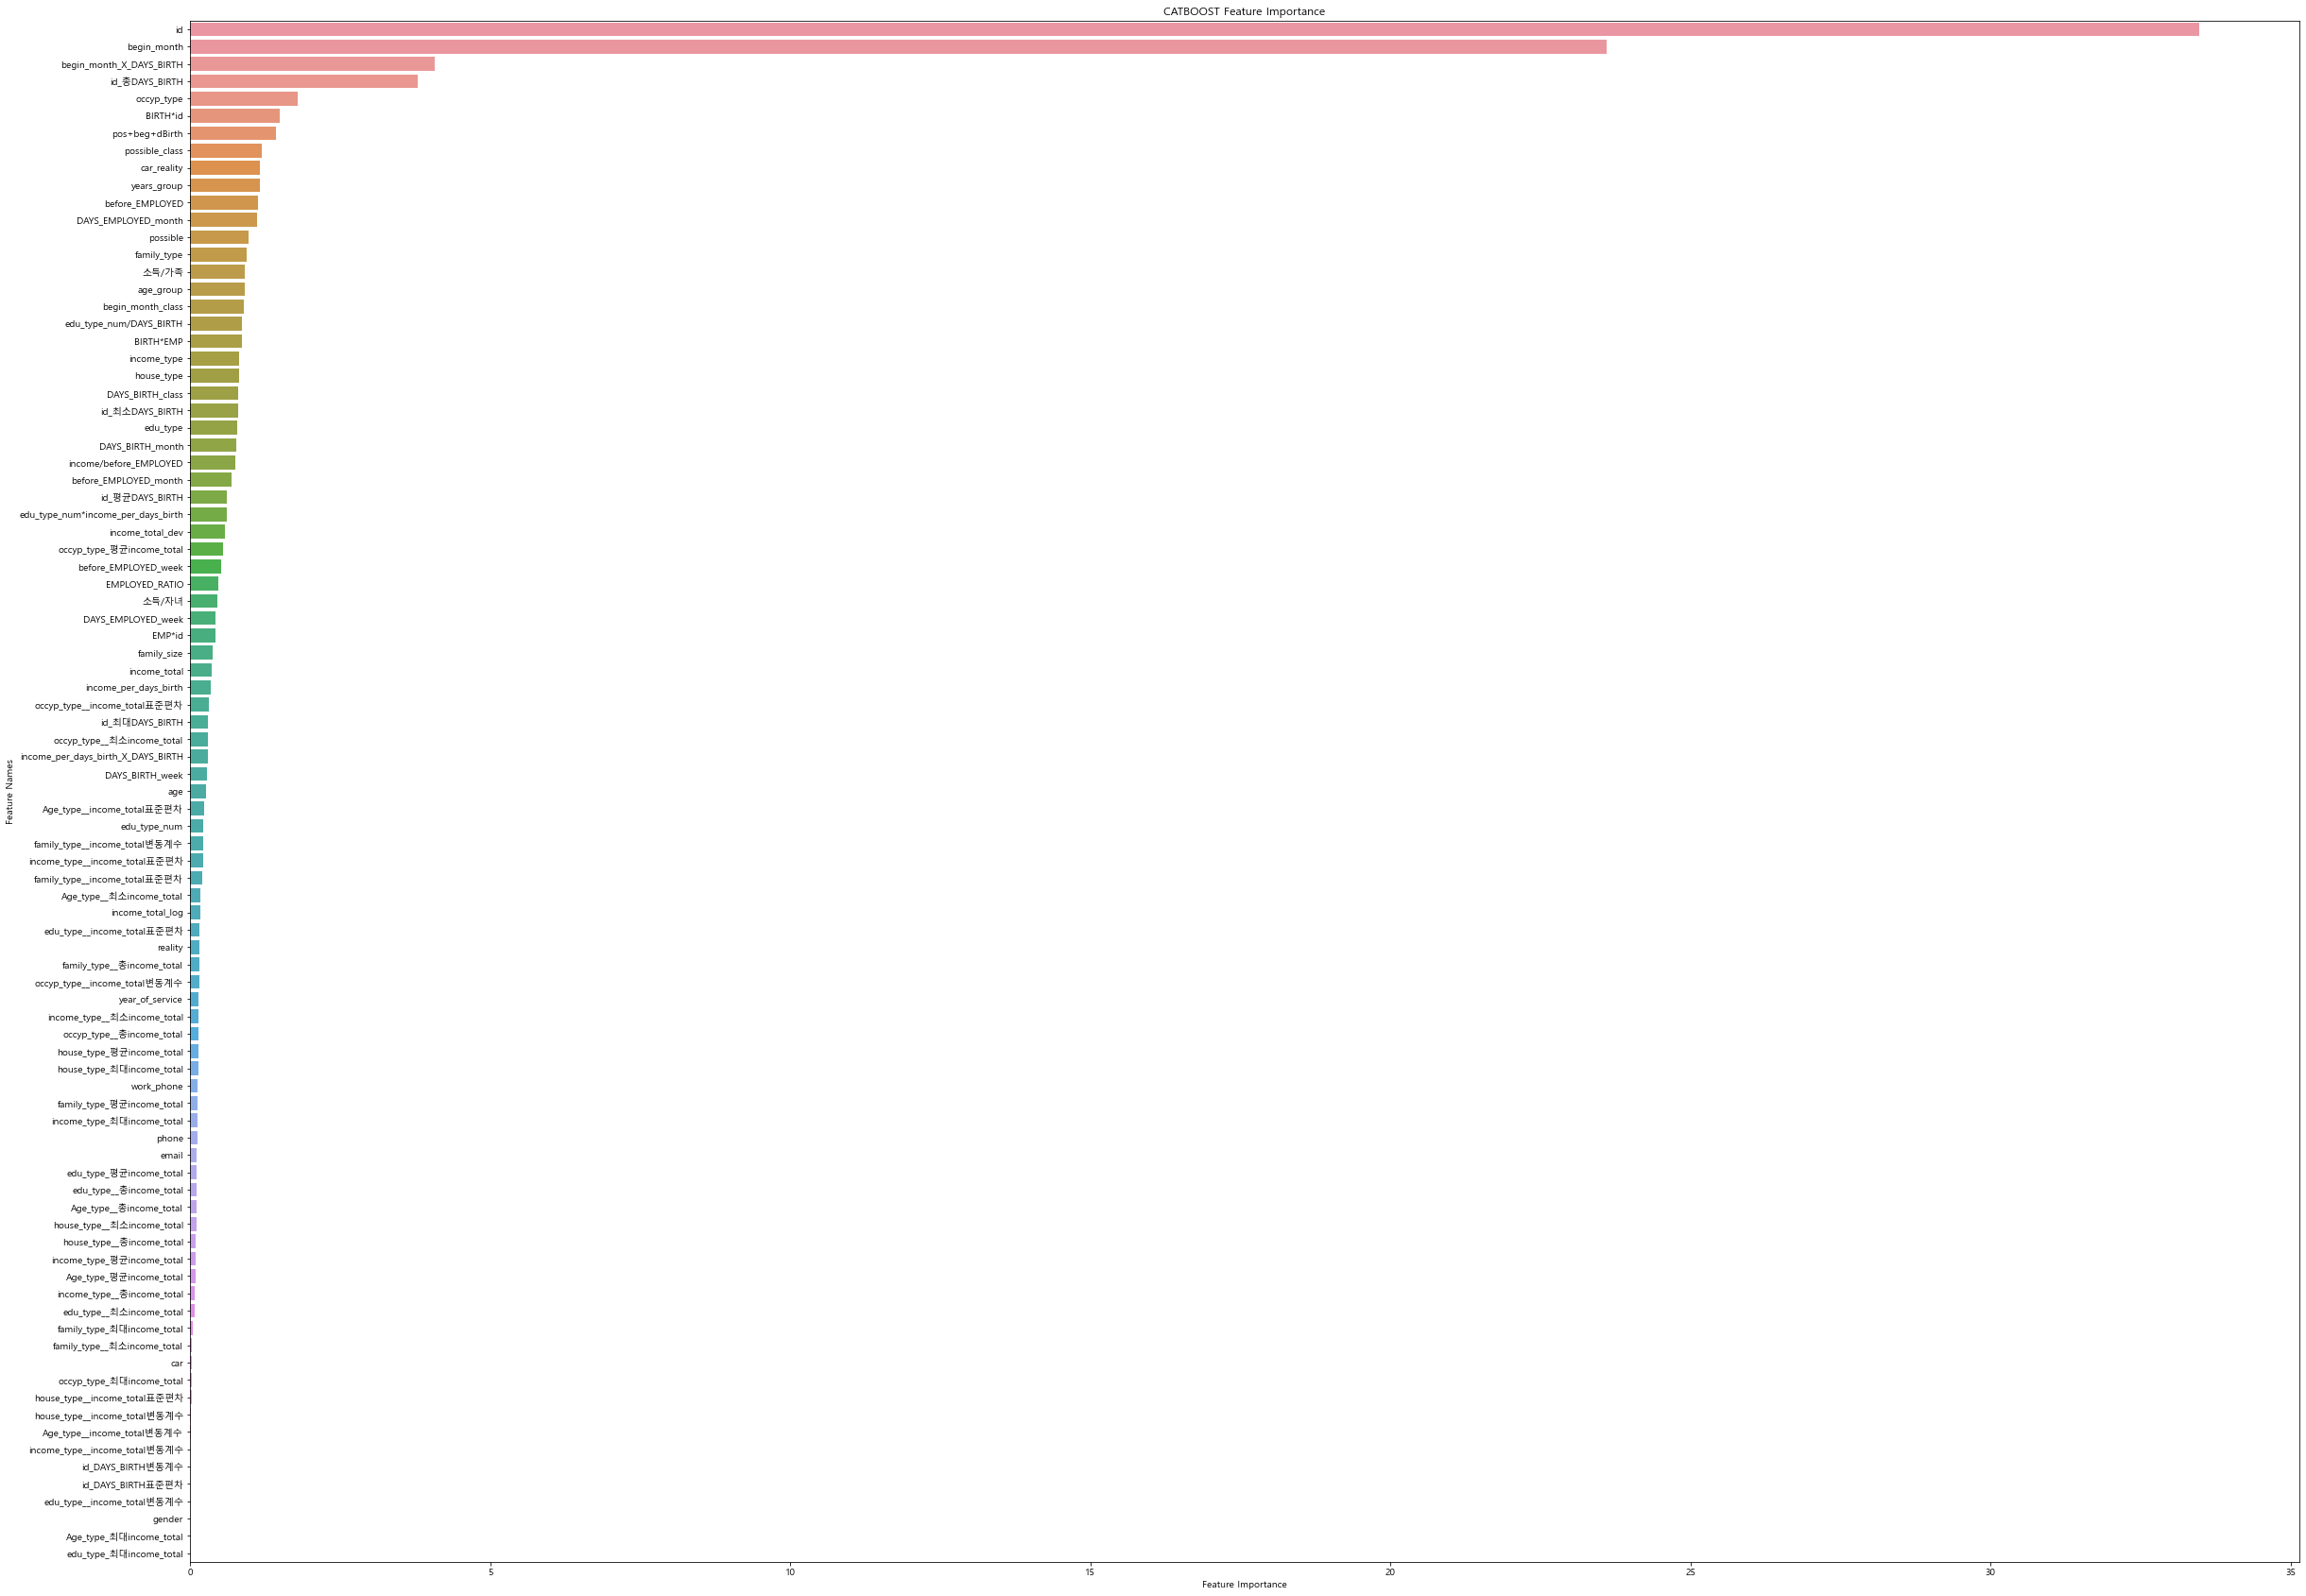

In [120]:
plot_feature_importance(model.get_feature_importance(),X_test.columns,'CATBOOST')


In [121]:
sub = pd.read_csv('data/sample_submission.csv')

In [122]:
sub.iloc[:, 1:] = cat_pred_test 

In [123]:
sub.to_csv(f"submission_cat_all_3.csv", index=False)